We scanned *a lot* of teeth for the ZMK guys and gals.
Let's programmatically generate overview images of them.

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
from tqdm import notebook
import dask
import dask.array as da
import dask_image.imread
from dask.distributed import Client
client = Client()
from numcodecs import Blosc

C:\ProgramData\Anaconda3\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52334 instead
  http_address["port"], self.http_server.port


In [2]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [3]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [4]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [5]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'ZMK')
print('We are loading all the data from %s' % Root)

We are loading all the data from F:\ZMK


In [6]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [7]:
# Look only for folders: https://stackoverflow.com/a/38216530
Data['Folder'] = glob.glob(os.path.join(Root, 'ToothBattallion', '*' + os.path.sep))

In [8]:
print('We found %s tooth folders in %s' % (len(Data), Root))

We found 8 tooth folders in F:\ZMK


In [9]:
# Look for the relevant logfiles
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Data['Folder']]

In [10]:
Data['Sample'] = [os.path.splitext(os.path.basename(l))[0] for l in Data['LogFile']]

In [11]:
# Drop all folders we don't need
# Andrea and Thomas decided we want to show two figures, one with tooths 27 and 35, the other one with tooths 41 an 93.
# https://stackoverflow.com/a/19960116/323100
Keepers = ['Tooth027', 'Tooth035', 'Tooth041', 'Tooth093']
Data = Data[Data.Sample.isin(Keepers)]
Data = Data.reset_index(drop=True)

In [12]:
Data

,Folder,LogFile,Sample
0,F:\ZMK\ToothBattallion\27\,F:\ZMK\ToothBattallion\27\proj\Tooth027.log,Tooth027
1,F:\ZMK\ToothBattallion\35\,F:\ZMK\ToothBattallion\35\proj\Tooth035.log,Tooth035
2,F:\ZMK\ToothBattallion\41\,F:\ZMK\ToothBattallion\41\proj\Tooth041.log,Tooth041
3,F:\ZMK\ToothBattallion\93\,F:\ZMK\ToothBattallion\93\proj\Tooth093.log,Tooth093


In [13]:
Data['Voxelsize'] = [get_pixelsize(l) for l in Data['LogFile']]

In [14]:
# Cropped filenames
Data['OutputNameRecCrop'] = [os.path.join(f, sample + '_rec_crop.zarr') for f, sample in zip(Data.Folder, Data.Sample)]

In [15]:
# Load the cropped zarr arrays 
CroppedReconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRecCrop']]

In [16]:
# Update the size
Data['Size'] = [rec.shape for rec in CroppedReconstructions]

In [17]:
Data

,Folder,LogFile,Sample,Voxelsize,OutputNameRecCrop,Size
0,F:\ZMK\ToothBattallion\27\,F:\ZMK\ToothBattallion\27\proj\Tooth027.log,Tooth027,9.999986,F:\ZMK\ToothBattallion\27\Tooth027_rec_crop.zarr,"(2414, 631, 705)"
1,F:\ZMK\ToothBattallion\35\,F:\ZMK\ToothBattallion\35\proj\Tooth035.log,Tooth035,9.999986,F:\ZMK\ToothBattallion\35\Tooth035_rec_crop.zarr,"(2528, 804, 710)"
2,F:\ZMK\ToothBattallion\41\,F:\ZMK\ToothBattallion\41\proj\Tooth041.log,Tooth041,9.999986,F:\ZMK\ToothBattallion\41\Tooth041_rec_crop.zarr,"(2037, 714, 718)"
3,F:\ZMK\ToothBattallion\93\,F:\ZMK\ToothBattallion\93\proj\Tooth093.log,Tooth093,9.999986,F:\ZMK\ToothBattallion\93\Tooth093_rec_crop.zarr,"(2086, 774, 716)"


In [18]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [19]:
# Read or calculate the directional MIPs of the cropped reconstructions
# Put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Data)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            try:
                # Generate MIP
                Data.at[c, 'MIP_' + direction] = CroppedReconstructions[c].max(axis=d).compute()
            except ZeroDivisionError:
                print('Something does not work for %s, copying uncropped MIP' % row['Sample'])
                Data.at[c, 'MIP_' + direction] = Data.at[c, 'MIP_' + direction]
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

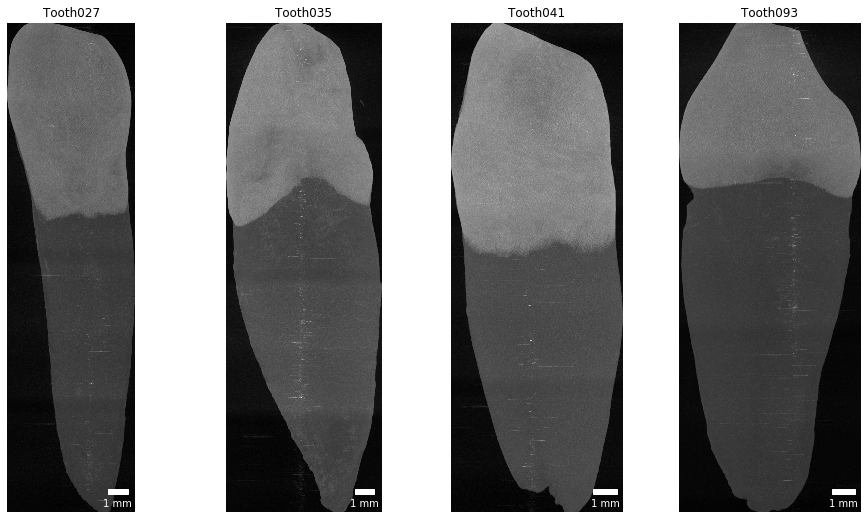

In [20]:
# Show MIPs
for c, row in Data.iterrows():
    plt.subplot(1,4,c+1)
    plt.imshow(row['MIP_Sagittal'])
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    plt.title(row['Sample'])
    plt.axis('off')
plt.show()

In [21]:
# Show MIPs
for c, row in Data.iterrows():
    print('%s has %s cropped reconstructions (at %s um) and is thus %s mm long' % (row.Sample,
                                                                                   row.Size[0],
                                                                                   row.Voxelsize,
                                                                                   round(row.Size[0] * row.Voxelsize / 1000, 2)))

Tooth027 has 2414 cropped reconstructions (at 9.999986 um) and is thus 24.14 mm long
Tooth035 has 2528 cropped reconstructions (at 9.999986 um) and is thus 25.28 mm long
Tooth041 has 2037 cropped reconstructions (at 9.999986 um) and is thus 20.37 mm long
Tooth093 has 2086 cropped reconstructions (at 9.999986 um) and is thus 20.86 mm long


In [42]:
# Load visualizations
# Those were made in MeVisLab
Data['Visualization'] = [imageio.imread(os.path.join(f,s+'.tif')) for f,s in zip(Data['Folder'],Data['Sample'])]

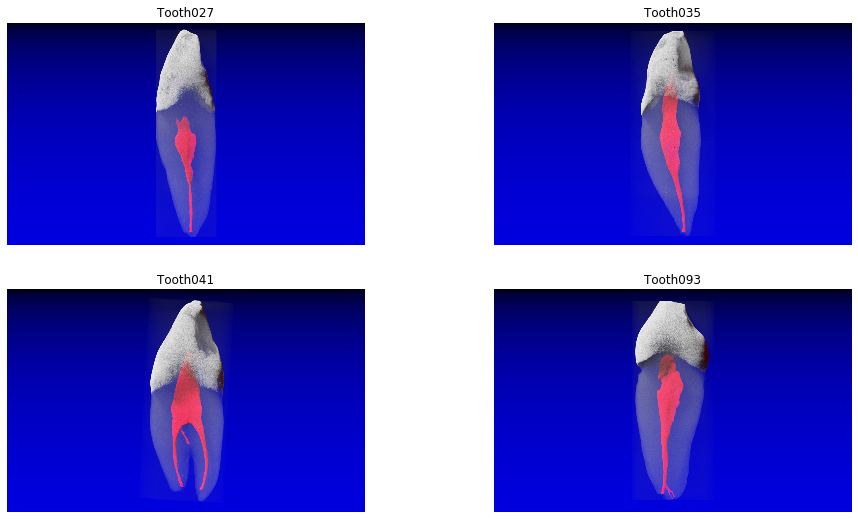

In [43]:
for c, row in Data.iterrows():
    plt.subplot(2,2,c+1)
    plt.imshow(row.Visualization)
    plt.title(row.Sample)
    plt.axis('off')
plt.show()